<a href="https://colab.research.google.com/github/Nsimaar99/Kaggle-Project/blob/master/Octopus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/udacity/deep-learning-v2-pytorch.git

Cloning into 'deep-learning-v2-pytorch'...
remote: Enumerating objects: 1731, done.
remote: Total 1731 (delta 0), reused 0 (delta 0), pack-reused 1731 (from 1)
Receiving objects: 100% (1731/1731), 149.30 MiB | 12.93 MiB/s, done.
Resolving deltas: 100% (835/835), done.
Updating files: 100% (270/270), done.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np

In [3]:
# Get the "Features" portion of VGG 19
vgg19 = models.vgg19(pretrained=True).features
# Freeze all VGG parameters since we are only optimizing the target image
for param in vgg19.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 130MB/s]


In [4]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Load in content and style images

In [ ]:
def load_image(img_path, max_size=400, shape=None):
  ''' Load in and transform an image, making sure the image
  is <= 400 pixels in the x-y dims.'''
  image = Image.open(img_path).convert('RGB')
  # Large image will slow down the processing
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406),
                           (0.229, 0.224, 0.225))])

  # Discard the transparent, alpha channel i.e the :3, and add the batch dimension
  image = in_transform(image)[:3, :, :].unsqueeze(0)

  return image

In [6]:
# Load in content and style image
content = load_image('/content/deep-learning-v2-pytorch/style-transfer/images/octopus.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/deep-learning-v2-pytorch/style-transfer/images/hockney.jpg', shape=content.shape[-2:]).to(device)

In [7]:
# helper function for un-normalizing an image
# and converting it from a Tensor image to a Numpy image
def im_convert(tensor):
  """ Display a tensor as an image. """
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

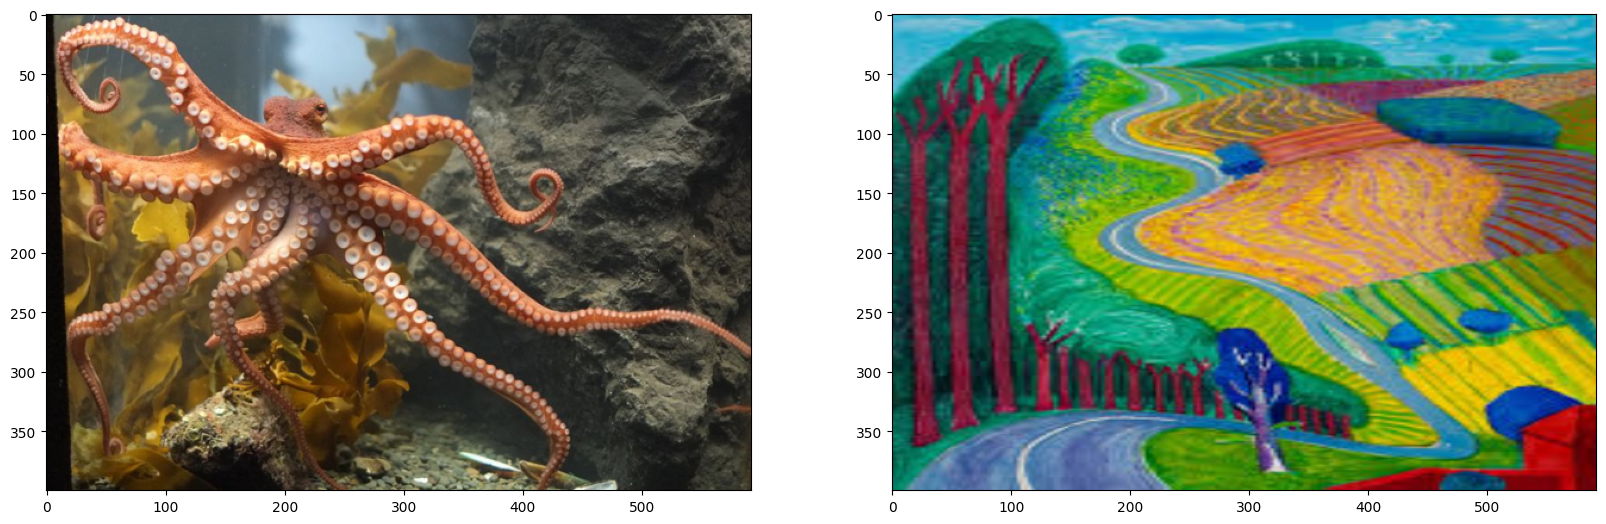

In [8]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

**VGG 19 Layers**
To get the content and style representations of an image, we have to pass an image forward through the VGG 19 network until we get to the desired layer(s) and then get the output from the layer.

In [9]:
# Print out VGG 199 structures so as to see the names of various layers
print(vgg19)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Pass an image through a model VGGNet and extract feature maps from specific layers

In [10]:
def get_features(image, model, layers=None):
    """
    Run an image forward through a model and get the features for
    a set of layers. Default layers are for VGGNet matching Gatys et al. (2016)
    """
    # If no specific layers are provided, default to the layers for style transfer
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # This layer is used for the content representation
                  '28': 'conv5_1'}

    # Create a dictionary to hold the features from each selected layer
    features = {}

    # Get the layers of the model
    x = image  # Input image
    for name, layer in model._modules.items():
        x = layer(x)  # Feed the image through each layer

        # If the current layer is in the layers we want to extract features from
        if name in layers:
            features[layers[name]] = x

    return features


Gram Matrix

In [11]:
def gram_matrix(tensor):
    """
    Calculate the Gram Matrix of a given tensor.

    The Gram Matrix is the result of multiplying a matrix by its transpose.
    In this case, the matrix is a reshaped version of the feature maps from a
    particular layer of a convolutional neural network.

    Args:
    - tensor (torch.Tensor): A feature map from a CNN of shape (batch_size, depth, height, width).

    Returns:
    - gram (torch.Tensor): The Gram matrix for the input feature map.
    """
    # Get the batch size, depth (number of feature maps), height, and width of the tensor
    _, d, h, w = tensor.size()

    # Reshape the tensor to be a 2D matrix where each row represents a feature map
    tensor = tensor.view(d, h * w)

    # Calculate the Gram matrix by multiplying the reshaped tensor with its transpose
    gram = torch.mm(tensor, tensor.t())

    # Normalize the Gram matrix by dividing by the number of elements in each feature map
    return gram.div(d * h * w)


In [12]:
# Get content and style features onlyl once before forming the target image
content_features = get_features(content, vgg19)
style_features = get_features(style, vgg19)

# Calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a third "target" image and prep it for change
# It is a good idea to start of with the target as a copy of our "content" image
# Then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

Loss and Weights

In [13]:
# Weight for each style layer
# Weighting earlier layers more will result in "larger" style artifacts
# Notice that we are excluding "conv4_2", our content representation

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.1}

content_weight = 1e2 # alpha
style_weight = 1e4  # beta

Updating the targets and calculating the losses

Total loss:  0.0016950216377153993


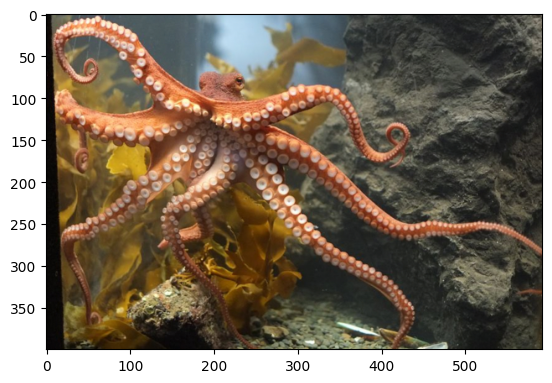

Total loss:  0.0019038391765207052


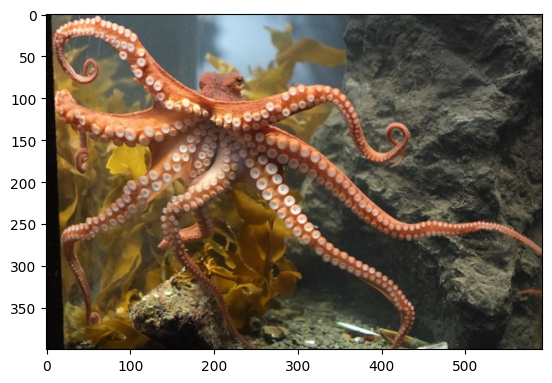

Total loss:  0.006453036330640316


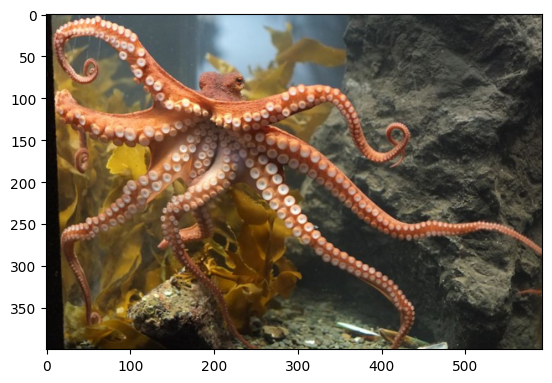

Total loss:  0.009445755742490292


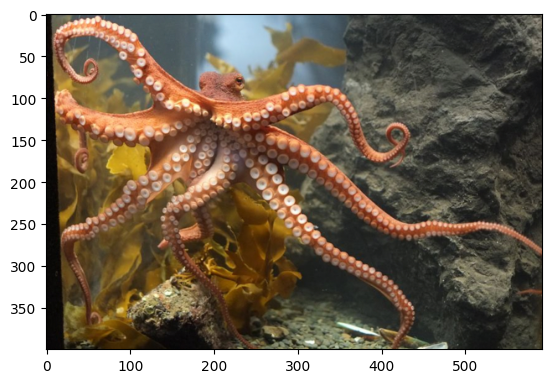

Total loss:  0.010068880394101143


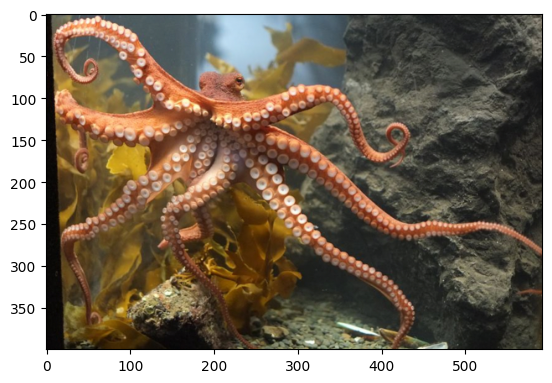

In [15]:
# For displaying target image, intermittently
show_every = 400

# Iteration parameters
optimizer = torch.optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update

for step in range(1, steps + 1):
  # Get features from your target image
  target_features = get_features(target, vgg19)

  # Calculate the content loss
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

  # Initialize the style loss to 0
  style_loss = 0

  # Loop over each layer and calculate the style loss
  for layer in style_weights:
    # Get the "target" style representation for the layer
    target_feature = target_features[layer]
    _, d, h, w = target_feature.shape

    # Calculate the target gram matrix
    target_gram = gram_matrix(target_feature)

    # Get the "style" style representation
    style_gram = style_grams[layer]

    # Calculate the style loss one layer, and weighted appropriately
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)

    # add to the style loss
    style_loss += layer_style_loss / (d * h * w)

  # Calculate the total loss
  total_loss = content_weight * content_loss + style_weight * style_loss

  # Update the target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  # Display the intermidiate image and print the loss
  if step % show_every == 0:
    print("Total loss: ", total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()

Display the target image

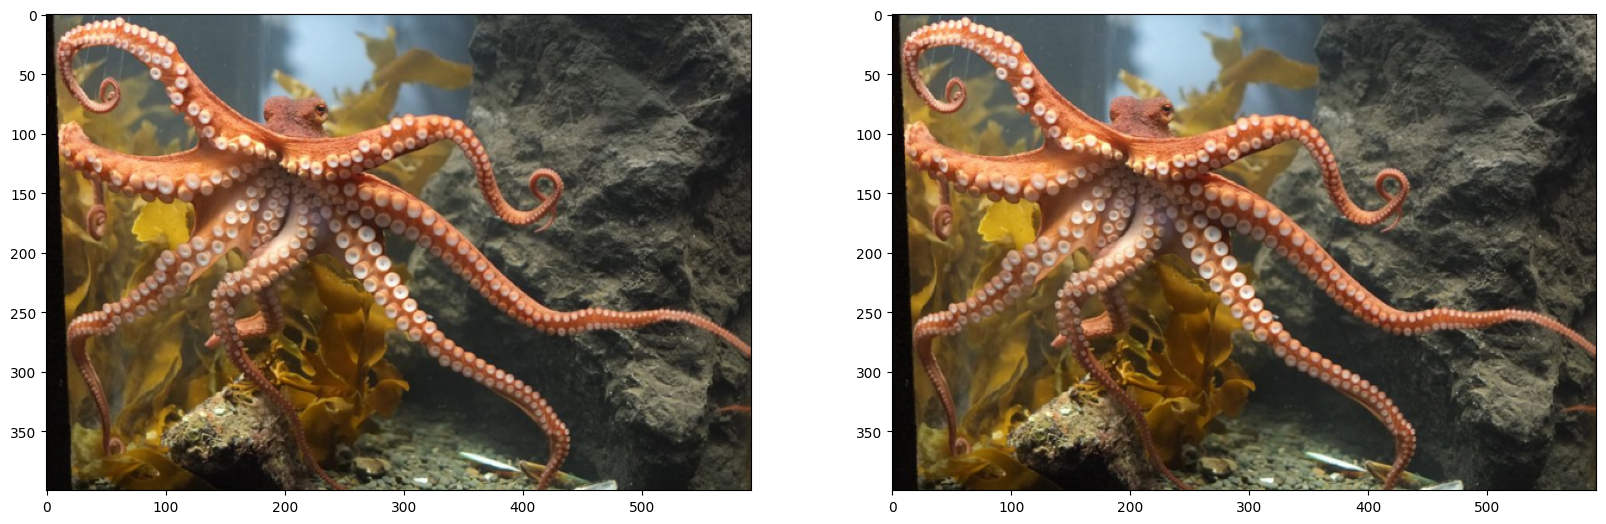

In [16]:
# Display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))